# Introduction to Machine Learning (CSCI-UA.473)

## Lab 4: Multiclass Classification, Weight Visualization, and Support Vector Machines
### Date: October 14th, 2021
### Name: (your name goes here)
### Email: (your NYU email goes here)

### Goal:  Demonstrate how to train a multiclass classifier and do some anecdotal analysis. In addition, we demonstrate some of the main concepts of Support Vector Machines (SVMs)

## Multiclass Classifier 

Import some essential packages

In [6]:
import numpy as np
import pandas as pd
from sklearn import datasets

import matplotlib.pyplot as plt

%matplotlib inline

### Setup Seed

For experiment reproducibility (in most cases), we need to make sure all sources of randomness are initialized with a seed. This includes the Python module `random` and `numpy`. Hence when developing/debugging the model it is a good practice to choose a seed and keep it fixed. After the development/debugging phase though, the experiments should be run using multiple seeds to make sure that the results don't fit to a single seed. 

**IMPORTANT**: Before using a random number generator from any module, make sure to set the seed using that module's seed function.

In [7]:
np.random.seed(12345)

### Fetch Data

Download the MNIST dataset file `mnist.npz` from `https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz`.

In [8]:
class MNIST:
    def __init__(self, path):
        mnist = np.load(path)

        self.train_labels = mnist['y_train']
        self.test_labels = mnist['y_test']

        self.train_data = mnist['x_train']
        self.train_data = self.train_data.reshape(self.train_data.shape[0], -1)
        self.test_data = mnist['x_test']
        self.test_data = self.test_data.reshape(self.test_data.shape[0], -1)

**NOTE**: Modify the `path` argument as desired.

In [9]:
path = '../data/mnist.npz'
mnist = MNIST(path)

Each digit is represented by a $784$-D vector (flattened $28 \times 28$ image) and has a corresponding target digit label.

In [10]:
mnist.train_data.shape, mnist.train_labels.shape

((60000, 784), (60000,))

Let's take a look at the digits distribution in the dataset.

In [11]:
pd.DataFrame({
    'count': np.bincount(mnist.train_labels),
    'digit': np.unique(mnist.train_labels)}, 
    columns=['digit', 'count'])

,digit,count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


### Create Train/Validation/Test Data

To make sure we create a model that generalizes well, we should train our model **ONLY** on "train" data, find the best performing model (validation) via the "validation" data and make sure no novel data ("test" data) leaks into the training or validation phase.

For illustration, we will use $5000$ training samples, $100$ validation and test samples, all chosen (pseudo-)randomly. We first randomly pick a set of indices from both train and test data.

In [12]:
num_train, num_val, num_test = 10000, 1000, 1000
sample_idx = np.random.choice(mnist.train_data.shape[0], num_train + num_val)
test_idx = np.random.choice(mnist.test_data.shape[0], num_test)
train_idx, val_idx = (sample_idx[:num_train], sample_idx[num_train:num_train + num_val])

Use numpy slicing to get the data at the indices sampled above.

In [13]:
train_data, train_labels = mnist.train_data[train_idx], mnist.train_labels[train_idx].astype(int)
val_data, val_labels = mnist.train_data[val_idx], mnist.train_labels[val_idx].astype(int)
test_data, test_labels = mnist.test_data[test_idx], mnist.test_labels[test_idx].astype(int)

Add the bias element directly into the original data by concatenating a column of ones.

In [14]:
train_data_tilde = np.concatenate([train_data, np.ones((train_data.shape[0], 1))], axis=1)
val_data_tilde = np.concatenate([val_data, np.ones((val_data.shape[0], 1))], axis=1)
test_data_tilde = np.concatenate([test_data, np.ones((test_data.shape[0], 1))], axis=1)

train_data_tilde.shape, val_data_tilde.shape, test_data_tilde.shape

((10000, 785), (1000, 785), (1000, 785))

### Visualize Train Data

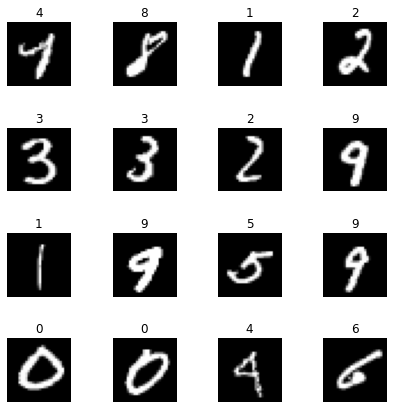

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
fig.tight_layout()

random_idx = np.random.choice(train_data.shape[0], size=16, replace=False)

for i in range(4):
    for j in range(4):
        idx = j + i * 4
        axes[i, j].set_title(train_labels[idx])
        axes[i, j].imshow(train_data[idx].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')

plt.show()

Let's also take a look at the label distribution for our newly created training data. Ideally, we would like them to be equal in number.

In [16]:
pd.DataFrame({
    'count': np.bincount(train_labels),
    'digit': np.unique(train_labels)}, 
    columns=['digit', 'count'])

,digit,count
0,0,997
1,1,1119
2,2,1002
3,3,998
4,4,983
5,5,936
6,6,965
7,7,1074
8,8,948
9,9,978


### Model Definition

We define a simple linear model which outputs the probability of incoming digit belonging to one of the $10$ classes.

$$ 
\begin{align}
p_i 
& = \text{softmax}(w^T \cdot x)_i \text{$x \in \mathbb{R}^{D+1}$, $w \in \mathbb{R}^{(D+1) \times K}$} \\
& = \frac{\exp^{w^T_i \cdot x}}{\sum_j \exp^{w^T_j \cdot x}} \text{$\forall j \in [1, K]$}
\end{align}
$$

$D = 784$ (the dimension of your input), $K = 10$ (total number of classes). 

In [17]:
def model(X, W):
    logits = np.matmul(X, W.T) / W.shape[-1]
    
    logits_exp = np.exp(logits)
    probs = logits_exp / np.sum(logits_exp, axis=1, keepdims=True)
    
    return probs


def mean_nll(output, target):
    prob = output[np.arange(output.shape[0]), target]
    neg_likelihood = - np.log(prob + 1e-9)
    return np.mean(neg_likelihood)


def one_hot(K, labels):
    B = labels.shape[0]
    output = np.zeros((B, K))
    output[np.arange(B), labels] = 1
    return output


def gradient(all_probs, X, y):
    B, K = all_probs.shape
    y_star = one_hot(K, y)
    grad = np.matmul((all_probs - y_star).T, X)
    return grad / B

def reg_gradient(lmbda, W) :
    return lmbda * W/W.shape[0]
    

def evaluate(W, X, y):
    all_probs = model(X, W)
    loss = mean_nll(all_probs, y)
    
    y_pred = np.argmax(all_probs, axis=1)
    y_correct = np.sum(y_pred == y)
    acc = y_correct / y.shape[0]

    return loss, acc


### Execute Training

We first initialize all weights randomly from a standard normal distribution and then run training until we see no further improvement (for a maximum of `n_epochs`).


#### Gradient Descent

Often times, we cannot solve for the true parameters in closed form and resort to an iterative procedure known as *gradient descent*. Further, using only one data sample to update the parameters is termed as *stochastic gradient descent*. The stochasticity (randomness) comes from the fact that we only use one sample and not the full data set. To maximize memory utilization, we take a subset of samples called a *mini-batch*, termed as *mini-batch stochastic gradient descent*. This technique is demonstrated in the example below.

The stochastic gradient descent algorithm involves a set of hyperparameters that typically require tuning based on the problem at hand. The learning rate is a multiplicative factor to the *stochastic gradient* which decides how far we jump in the gradient direction (modifies the magnitude of the gradient). As we start getting closer to the optimum value, we would like to slow down so as to not make large jumps in the parameter ($\mathbf{W}$) space. This schedule of decreasing the learning rate is known as *annealing*. In the example below, we anneal from a learning rate of $0.1$ to $0.001$ over $30$ epochs.

Initialize the weight vector randomly from a standard normal distribution (Gaussian distribution with mean=0 and standard deviation=1)

In [18]:
K = np.unique(mnist.train_labels).shape[0]
D = mnist.train_data.shape[-1]

w = np.random.normal(size=(K, D+1))
w.shape

(10, 785)

In [19]:
n_epochs = 500
batch_size = 50
lr0 = 0.1
lrf = 0.001
anneal_over = 50
improvement = 0.999
lmbda = 0

best_w, old_loss = None, np.Inf

lr = lr0
for e in range(n_epochs):
    if (e + 1)% anneal_over == 0:
        print('Annealing the learning rate')
        lr = max(lrf, lr/2)
    

    for b in range(num_train // batch_size):
        minibatch_X = train_data_tilde[b * batch_size:(b + 1) * batch_size]
        minibatch_y = train_labels[b * batch_size:(b + 1) * batch_size]

        all_probs = model(minibatch_X, w)

        grad = gradient(all_probs, minibatch_X, minibatch_y) + reg_gradient(lmbda, w)
      #  reg_grad = reg_gradient(0.01, w)

        w -= lr * grad
    
    val_loss, val_acc = evaluate(w, val_data_tilde, val_labels)
    print ('epoch {:4d} : lr {:.4f} acc {:.4f} | loss {:.5f}'.format(e, lr, val_acc, val_loss))
    
    if val_loss < old_loss:
        best_w = w 
        old_loss = val_loss
        
test_loss, test_acc = evaluate(best_w, test_data_tilde, test_labels)
print ('test acc {:.4f} | loss {:.5f}'.format(test_acc, test_loss))

epoch    0 : lr 0.1000 acc 0.8140 | loss 2.43221
epoch    1 : lr 0.1000 acc 0.8270 | loss 2.19105
epoch    2 : lr 0.1000 acc 0.8460 | loss 1.91361
epoch    3 : lr 0.1000 acc 0.8790 | loss 1.31533
epoch    4 : lr 0.1000 acc 0.8310 | loss 1.94764
epoch    5 : lr 0.1000 acc 0.9000 | loss 1.15495
epoch    6 : lr 0.1000 acc 0.8460 | loss 1.66730
epoch    7 : lr 0.1000 acc 0.8500 | loss 1.68435
epoch    8 : lr 0.1000 acc 0.8260 | loss 2.06236
epoch    9 : lr 0.1000 acc 0.8790 | loss 1.43675
epoch   10 : lr 0.1000 acc 0.8600 | loss 1.65642
epoch   11 : lr 0.1000 acc 0.8720 | loss 1.42897
epoch   12 : lr 0.1000 acc 0.8480 | loss 1.70399
epoch   13 : lr 0.1000 acc 0.8450 | loss 1.80872
epoch   14 : lr 0.1000 acc 0.8780 | loss 1.31069
epoch   15 : lr 0.1000 acc 0.8920 | loss 1.27742
epoch   16 : lr 0.1000 acc 0.8710 | loss 1.41398
epoch   17 : lr 0.1000 acc 0.8460 | loss 1.78167
epoch   18 : lr 0.1000 acc 0.8760 | loss 1.39668
epoch   19 : lr 0.1000 acc 0.8650 | loss 1.59545
epoch   20 : lr 0.10

If you run this code block multiple times, you should observe that the test accuracy goes further up. 

**WARNING**: However, feedback from the test set is NOT the right way.

### Visualize Features

If everything goes well, we should be able to visualize each row of the parameter matrix $W$ defined above and start seeing some patterns. Intuitively, these can be thought of as a visual association of parameters with parts of the image space. Brighter the visual, higher the response signal on interaction with the input.

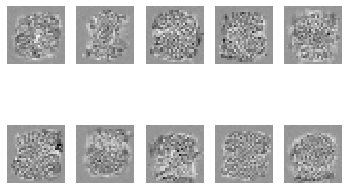

In [20]:
fig, axes = plt.subplots(2, 5)
weights = best_w[:,:-1].copy()
scale = np.abs(weights).max()
for i in range(2):
    for j in range(5):
        idx = j + i * 5
        axes[i, j].imshow(weights[idx].reshape(28, 28),interpolation='nearest', cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
        axes[i, j].axis('off')

plt.show()

## Support Vector Machines
We will now play around with the support vector machine. We will first compare them to a standard logistic regression model. Then we will see how they work on datasets which are not linearly separable. 

Import some necessary packages

In [21]:
# Start by importing the packages we'll need.
import numpy as np
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt

### Implement Linear SVMs
We will implement a linear SVM for the task of breast cancer classification. 

First load the dataset and split it into training and validation set. 

In [22]:
# We'll set a random seed first.
np.random.seed(19)

# First load the data.
data = datasets.load_breast_cancer()
X = data.data   # The features.
y = data.target # The targets.

# Print the dataset sizes.
print('Shape of X = ', X.shape)
print('Shape of y = ', y.shape)

# Split the data into a training and test set.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 7)

Shape of X =  (569, 30)
Shape of y =  (569,)


Now train a linear SVM using scikit-learn. In addition also train a logistic regression model also using scikit-learn.

In [23]:
# Train the linear SVM.

svm = LinearSVC(dual = False) # Uses the squared-hinge loss function when fitting the model.
svm.fit(X_train, y_train)

# Now evaluate it on the test points.
y_pred = svm.predict(X_val)

acc = metrics.accuracy_score(y_val, y_pred)
print('Linear SVM validation accuracy = {:0.1f}%'.format(100*acc))

# Compare to a simple logistic regression model.

lr = LogisticRegression(solver = 'liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

acc = metrics.accuracy_score(y_val, y_pred)
print('Logistic Regression validation accuracy = {:0.1f}%'.format(100*acc))

Linear SVM validation accuracy = 95.7%
Logistic Regression validation accuracy = 95.2%


As we can see, a basic linear SVM already does very well and is comparable to logistic regression.

Let's compare logistic regression with SVM for binary classification.  Suppose that our data has $n$ features and we have trained a logistic regression model with weight vector $\theta_{\mathrm{LR}}\in \mathbb{R}^{n+1}$ as well as a linear SVM with parameters $w_{\mathrm{SVM}}\in \mathbb{R}^n$, and $b_{\mathrm{SVM}}\in \mathbb{R}$.  Assume that the optimal parameters have been found in both cases.  If the data is linearly separable then is it true that $\theta_{\mathrm{LR}} = (b_{\mathrm{SVM}}, w_{\mathrm{SVM}})$? 

If not then why?

**They will not be the same in general.**

Consider the dataset $X = (-5, -1, 1, 2)^T$ and $y = (-1, -1, 1, 1)^T$ (equivalently $y = (0,0,1,1)^T$ for logistic regression).  The SVM parameters will just be $(b_{\mathrm{SVM}}, w_{\mathrm{SVM}}) = (0,1)$.  However, the logistic regression parameters will be slightly different.  Recall the gradient of the loss function for logistic regression is
$$
\nabla_{\theta}J(\theta) = -\sum_{i=1}^4 (y_i - h(X_i;\theta))X_i
$$
where
$$
h(x;\theta) = \frac{1}{1 + \exp(-\theta^Tx)}
$$
However, if we plug all of the values into the gradient we get
$$
\nabla_{\theta}J((b_{\mathrm{SVM}}, w_{\mathrm{SVM}})) = -\left( \frac{5}{1+e^{5}} + \frac{1}{1+e^{1}} + \frac{e^{-1}}{1+e^{-1}} +  \frac{2e^{-2}}{1 + e^{-2}} \right) \neq 0
$$
Since the gradient is non-zero we know that $(b_{\mathrm{SVM}}, w_{\mathrm{SVM}})$ is not the optimal value for the logistic regression loss function and hence cannot be $\theta_{\mathrm{LR}}$.

### Case of non-linearly separable dataset

If the data is linear separable, then a linear SVM should be able to achieve 100% accuracy.  However, this is rarely the case since even the breast cancer dataset was not exactly linear separable.  We'll use a fake dataset to illustrate this.  This data is drawn from a bi-modal Gaussian mixture model.

In [24]:
"""
Input:
    N : the number of data points

Output:
    X, y : the features and targets of shapes (N,2) and (N, )
"""
def sample_bimodal_data(N):
    
    # The two modes and covariances.
    mu1 = np.asarray([-1, 0])
    mu2 = np.asarray([1, 0])
    
    cov1 = 2 * np.identity(2)
    cov2 = 2 * np.identity(2)
    
    N1 = N//2   # Number of points in first class.
    N2 = N - N1 # Number of points in second class.
    
    # Sample the random points.
    X1 = np.random.multivariate_normal(mu1, cov1, N1)
    X2 = np.random.multivariate_normal(mu2, cov2, N2)
    Y1 = np.zeros(N1)
    Y2 = np.ones(N2)
    
    # Combine the data.
    X = np.vstack((X1, X2))
    Y = np.concatenate((Y1, Y2), axis = None)
    
    return X,Y

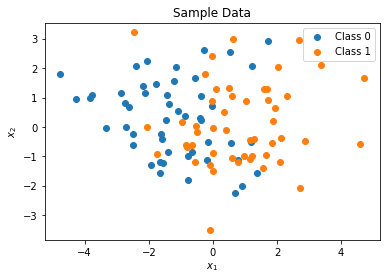

In [25]:
# Plot the sample data.
N = 100
X,Y = sample_bimodal_data(N)

plt.figure(1)
plt.scatter(X[:N//2, 0], X[:N//2, 1], label = 'Class 0')
plt.scatter(X[N - N//2:, 0], X[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sample Data');

Increasing the factor in front of the covariances or shifting the centers of the two distributions to be closer to each other will cause the data to overlap more, making it harder to classify. Lets try that! 

#### Using a slack variable C

Since the data is not perfectly linearly separable you'll want to use a slack variable which allows SVM to handle this dataset.  Let's train some models with different values of $C$ and compare them using cross-validation.

In [26]:
# First get the data and split it into training and testing.

N = 100
X, Y = sample_bimodal_data(N)

# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size = 0.30, random_state = 981)

SVM accuracy = 66.7%


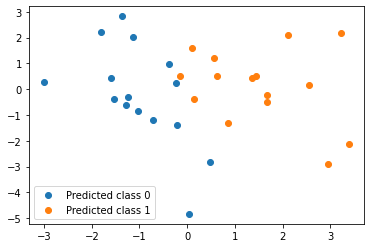

In [27]:
# Define the SVM model to use with a slack variable
svm = LinearSVC(C = 1e-10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

plt.figure(2)
I = svmpred == 0
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'Predicted class 0')
I = svmpred == 1
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'Predicted class 1')
plt.legend()
plt.show()

**Experiment with various different mu1 values and demonstrate SVM accuracy gets worse as mu1 and mu2 get closer**


Let's train some models with different $C$ and compare them use cross-validation.

In [28]:
# Define the different SVM models to use
svm_1 = LinearSVC(C = 10, dual = False)
svm_2 = LinearSVC(C = 1, dual = False)
svm_3 = LinearSVC(C = 1e-3, dual = False)
svm_4 = LinearSVC(C = 1e-7, dual = False)

split = model_selection.KFold(5)
# Get the CV scores.
cv_1 = model_selection.cross_val_score(svm_1, X_train, Y_train, cv = split)
cv_2 = model_selection.cross_val_score(svm_2, X_train, Y_train, cv = split)
cv_3 = model_selection.cross_val_score(svm_3, X_train, Y_train, cv = split)
cv_4 = model_selection.cross_val_score(svm_4, X_train, Y_train, cv = split)

# Print the average scores.
print('C = 10    CV average score = {:0.1f}%'.format(np.mean(cv_1) * 100))
print('C = 1     CV average score = {:0.1f}%'.format(np.mean(cv_2) * 100))
print('C = 1e-3  CV average score = {:0.1f}%'.format(np.mean(cv_3) * 100))
print('C = 1e-7  CV average score = {:0.1f}%'.format(np.mean(cv_4) * 100))

C = 10    CV average score = 72.9%
C = 1     CV average score = 72.9%
C = 1e-3  CV average score = 75.7%
C = 1e-7  CV average score = 77.1%


We see that the model performs slightly differently for different values of the slack variable $C$.  

$$
\min_{w,b,\zeta} \frac{1}{2}w^Tw + C\sum_{i=1}^n \zeta_i,\quad \text{ such that }\quad y_i(w^Tx_i + b) \ge 1 - \zeta_i,\quad \zeta_i \ge 0
$$

See the sci-kit [documentation](https://scikit-learn.org/stable/modules/svm.html) for more details.  We can also plot a curve of the validation score for many different $C$ values which can be helpful for determining the optimal hyperparameter.

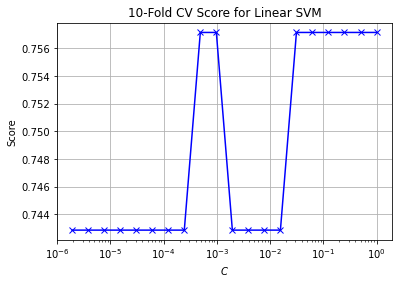

In [29]:
# Get the C values we want to look at.
C = 1/(2**np.arange(0, 20)) # 1,...,1e-6

k = 10 # Kfold CV.
cv_scores = np.zeros(len(C))
split = model_selection.KFold(k)
for i in range(len(C)):
    svm = LinearSVC(C = C[i], dual = False)
    cv_scores[i] = np.mean(model_selection.cross_val_score(svm, X_train, Y_train, cv = split))

plt.figure(2)
plt.semilogx(C, cv_scores, 'b-x')
plt.xlabel(r'$C$')
plt.ylabel(r'Score')
plt.title(r'{:d}-Fold CV Score for Linear SVM'.format(k))
plt.grid();

We can use this plot to find the optimal value of the slack variables based on the cross validation score. Now let's see how our 4 models from earlier actually do on the validation set.

In [30]:
# Define the different SVM models to use
svm_1 = LinearSVC(C = 10, dual = False)
svm_2 = LinearSVC(C = 1, dual = False)
svm_3 = LinearSVC(C = 1e-3, dual = False)
svm_4 = LinearSVC(C = 1e-7, dual = False)

# Fit the models.
svm_1.fit(X_train, Y_train)
svm_2.fit(X_train, Y_train)
svm_3.fit(X_train, Y_train)
svm_4.fit(X_train, Y_train)

# Make the predictions.
pred1 = svm_1.predict(X_val)
pred2 = svm_2.predict(X_val)
pred3 = svm_3.predict(X_val)
pred4 = svm_4.predict(X_val)

# Evaluate the models.
acc1 = metrics.accuracy_score(Y_val, pred1)
acc2 = metrics.accuracy_score(Y_val, pred2)
acc3 = metrics.accuracy_score(Y_val, pred3)
acc4 = metrics.accuracy_score(Y_val, pred4)

print('Linear SVM (C = 10)   accuracy = {:0.1f}%'.format(100*acc1))
print('Linear SVM (C = 1)    accuracy = {:0.1f}%'.format(100*acc2))
print('Linear SVM (C = 1e-3) accuracy = {:0.1f}%'.format(100*acc3))
print('Linear SVM (C = 1e-7) accuracy = {:0.1f}%'.format(100*acc4))

Linear SVM (C = 10)   accuracy = 56.7%
Linear SVM (C = 1)    accuracy = 56.7%
Linear SVM (C = 1e-3) accuracy = 63.3%
Linear SVM (C = 1e-7) accuracy = 66.7%


### Another non-linearly separable dataset

In [31]:
"""
Input:
    N : the number of data points

Output:
    X, y : the features and targets of shapes (N,2) and (N, )
"""
def gen_data1(N):
    N1 = N//2
    N2 = N - N1
    t = np.linspace(0, 2*np.pi, N1)
    
    X1 = np.zeros((N1, 2))
    X1[:,0] = 4*np.cos(t) + 0.1*np.random.randn(N1)
    X1[:,1] = 4*np.sin(t) + 0.1*np.random.randn(N1)
    y1 = np.zeros(N1)
    
    X2 = np.random.randn(2*N2)
    X2 = X2.reshape((N2, 2))
    y2 = np.ones(N2)

    # Combine the data.
    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2), axis = None) # axis = None means that arrays flattened before use
    
    return X,y

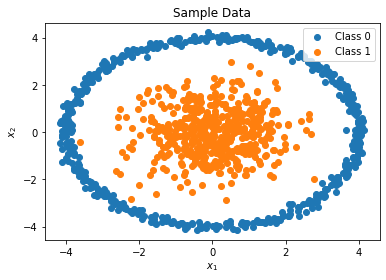

In [32]:
# Plot the data.
N = 1000
X, Y = gen_data1(N)

plt.figure(3)
plt.scatter(X[:N//2, 0], X[:N//2, 1], label = 'Class 0')
plt.scatter(X[N - N//2:, 0], X[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sample Data');

SVM accuracy = 40.0%


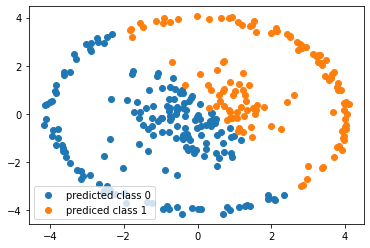

In [33]:
# Define the different SVM models to use
# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size = 0.3, random_state = 981)
svm = LinearSVC(C = 1e+10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

plt.figure(2)
I = svmpred == 0
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'predicted class 0')
I = svmpred == 1
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'prediced class 1')
plt.legend()
plt.show()

Here the data is not linearly separable although we can very clearly see some separation. If we transform the data by only looking at the radius, then we would be able to linearly separate the data. We will visit this in the next lecture when we talk about kernel SVM's which are much more flexible models and can handle a wider array of datasets.

(1000, 2)


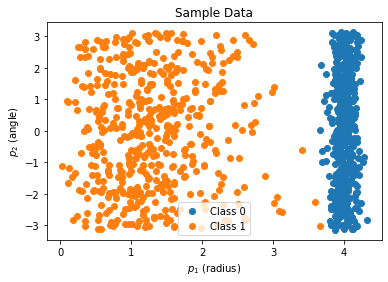

In [34]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

pX = np.vstack(cart2pol(X[:, 0], X[:, 1])).T
print(pX.shape)
plt.figure(4)
plt.scatter(pX[:N//2, 0], pX[:N//2, 1], label = 'Class 0')
plt.scatter(pX[N - N//2:, 0], pX[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$p_1$ (radius)')
plt.ylabel(r'$p_2$ (angle)')
plt.title('Sample Data');

In [35]:
# Define the different SVM models to use
# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(pX, Y, test_size = 0.3, random_state = 981)
svm = LinearSVC(C = 1e+10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

SVM accuracy = 100.0%
